## gridding polygons

In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pylab as plt

In [2]:
def make_legend(fig, colormap, loc=(1.05, .6), title='',fontsize=12):
    """Make a figure legend wth provided color mapping"""

    import matplotlib.patches as mpatches
    pts=[]
    for c in colormap:
        pts.append(mpatches.Patch(color=colormap[c],label=c))
    fig.legend(handles=pts,bbox_to_anchor=loc,fontsize=fontsize,title=title)
    return pts

def random_colors(n=10, seed=1):
    """Generate random hex colors as list of length n."""

    import random
    random.seed(seed)
    clrs=[]
    for i in range(n):
        r = lambda: random.randint(0,255)
        c='#%02X%02X%02X' % (r(),r(),r())
        clrs.append(c)
    return clrs

def get_color_mapping(df, col, cmap=None, seed=1):
    """Get random color map for categorical dataframe column"""

    c = df[col].unique()
    if cmap == None:
        rcolors = random_colors(len(c),seed)
    else:
        cmap = mpl.cm.get_cmap(cmap)
        rcolors = [cmap(i) for i in range(len(c))]
    colormap = dict(zip(c, rcolors))
    newcolors =  [colormap[i] if i in colormap else 'Black' for i in df[col]]
    return newcolors, colormap



In [7]:
def create_grid(gdf=None, bounds=None, n_cells=10, overlap=False, crs="EPSG:29902"):
    """Create square grid that covers a geodataframe area
    or a fixed boundary with x-y coords
    returns: a GeoDataFrame of grid polygons
    """

    import geopandas as gpd
    import shapely

    if bounds != None:
        xmin, ymin, xmax, ymax= bounds
    else:
        xmin, ymin, xmax, ymax= gdf.total_bounds

    # get cell size
    cell_size = (xmax-xmin)/n_cells
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            x1 = x0-cell_size
            y1 = y0+cell_size
            poly = shapely.geometry.box(x0, y0, x1, y1)
            #print (gdf.overlay(poly, how='intersection'))
            grid_cells.append( poly )

    cells = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                     crs=crs)
    if overlap == True:
        cols = ['grid_id','geometry','grid_area']
        cells = cells.sjoin(gdf, how='inner').drop_duplicates('geometry')
    return cells

def create_hex_grid(gdf=None, bounds=None, n_cells=10, overlap=False, crs="EPSG:29902"):
    """Hexagonal grid over geometry.
    See https://sabrinadchan.github.io/data-blog/building-a-hexagonal-cartogram.html
    """

    from shapely.geometry import Polygon
    import geopandas as gpd
    if bounds != None:
        xmin, ymin, xmax, ymax= bounds
    else:
        xmin, ymin, xmax, ymax= gdf.total_bounds

    unit = (xmax-xmin)/n_cells
    a = np.sin(np.pi / 3)
    cols = np.arange(np.floor(xmin), np.ceil(xmax), 3 * unit)
    rows = np.arange(np.floor(ymin) / a, np.ceil(ymax) / a, unit)

    #print (len(cols))
    hexagons = []
    for x in cols:
      for i, y in enumerate(rows):
        if (i % 2 == 0):
          x0 = x
        else:
          x0 = x + 1.5 * unit

        hexagons.append(Polygon([
          (x0, y * a),
          (x0 + unit, y * a),
          (x0 + (1.5 * unit), (y + unit) * a),
          (x0 + unit, (y + (2 * unit)) * a),
          (x0, (y + (2 * unit)) * a),
          (x0 - (0.5 * unit), (y + unit) * a),
        ]))

    grid = gpd.GeoDataFrame({'geometry': hexagons},crs=crs)
    grid["grid_area"] = grid.area
    grid = grid.reset_index().rename(columns={"index": "grid_id"})
    if overlap == True:
        cols = ['grid_id','geometry','grid_area']
        grid = grid.sjoin(gdf, how='inner').drop_duplicates('geometry')
    return grid

In [14]:
counties = gpd.read_file('data/counties.shp')
counties = counties.to_crs("EPSG:3857")

(-1227757.2698642802, -543883.7940439627, 6651671.728778979, 7503033.69564144)

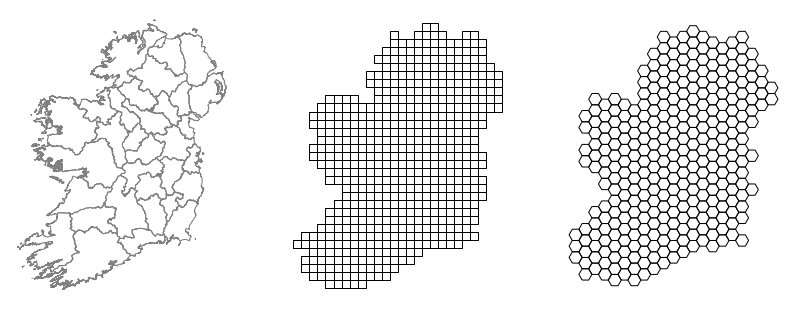

In [16]:
fig,ax = plt.subplots(1,3,figsize=(14,7))
axs=ax.flat
counties.plot(ec='gray',fc="none",figsize=(10,10),ax=axs[0])
gr = create_grid(counties, n_cells=25, overlap=True, crs="EPSG:3857")
gr.plot(fc="none", ec='black',ax=axs[1])
hexgr = create_hex_grid(counties, n_cells=30, overlap=True, crs="EPSG:3857")
#hexgr = hexgr.sjoin(counties, how='left')
hexgr.plot(fc="none", ec='black',ax=axs[2])
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

Text(0.5, 0.98, 'Ireland counties')

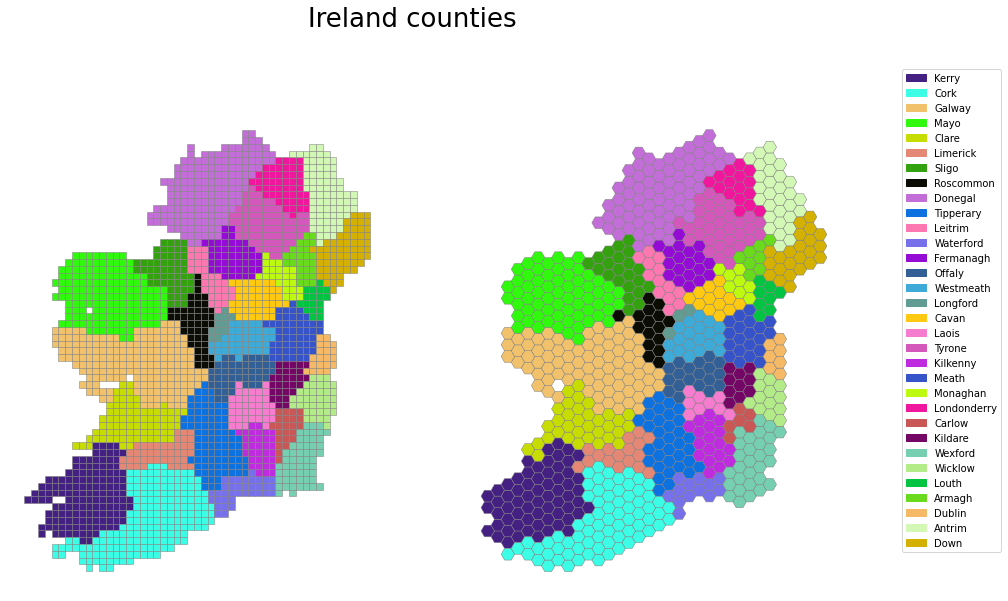

In [17]:
fig,ax = plt.subplots(1,2,figsize=(15,10))
axs=ax.flat
types=['square','hex']
funcs = [create_grid,create_hex_grid]
i=0
colors,nmap=get_color_mapping(gr, 'NAME_TAG')   
for func in funcs:    
    ax=axs[i]
    gr = func(counties, n_cells=50, overlap=True, crs="EPSG:3857")
    gr['value'] = gr.apply(lambda x: np.random.normal(10),1)
    gr['color'] = gr.NAME_TAG.map(nmap)
    gr.plot(color=gr.color,ec='gray',lw=.5,ax=ax)    
    ax.axis('off')
    i+=1
make_legend(fig,nmap,loc=(1.05, .9),fontsize=10)
fig.suptitle('Ireland counties',fontsize=26)

## Irish forestry example

In [101]:
forests = gpd.read_file('forestry_data/landuse_forests.shp')
forests = forests.to_crs("EPSG:3857")
woods = gpd.read_file('forestry_data/natural_wood.shp')
woods = woods.to_crs("EPSG:3857")
total = pd.concat([forests,woods])
total['area'] = total.to_crs('EPSG:6933').geometry.area/10**6

In [300]:
def grid_summary(gdf, data, n_cells=20):
    """Get grid summary from a map and associated meta data"""
    
    cols=['geometry','NAME_TAG']
    #get grid    
    grid = create_hex_grid(gdf, n_cells=n_cells, overlap=True, crs="EPSG:3857")[cols]
    #get centroids as alternative to polygons
    cent = data.copy()
    cent.geometry = data.centroid
    #sjoin merges on spatial overlap
    merged = gpd.sjoin(cent, grid, how='inner', predicate='intersects')
    #aggregate
    dissolve = merged.dissolve(by="index_right", aggfunc='sum')
    #print (dissolve)
    grid.loc[dissolve.index, 'value'] = dissolve['area'].values
    return grid

gdf = grid_summary(wc, wicklow, n_cells=5)

## wicklow subset example

(-765404.0305302762, -658359.0120385218, 6916039.066059159, 7045179.990831513)

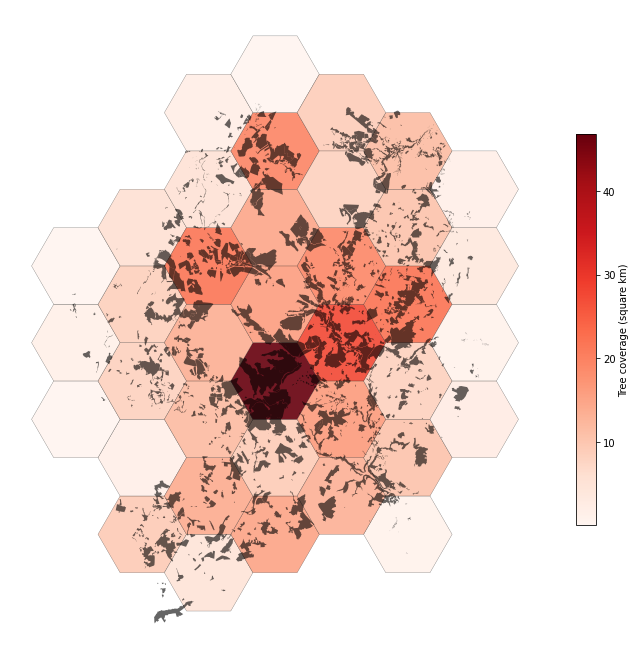

In [301]:
wicklow = total[total.county.isin(['Wicklow'])]
wc = counties[counties.NAME_TAG=='Wicklow']
gdf = grid_summary(wc, wicklow, n_cells=10)
fig,ax=plt.subplots(1,1,figsize=(12,12))
gdf.plot(column='value',ec='black',lw=0.2,legend=True, cmap='Reds',alpha=0.9,
          legend_kwds={'label': "Tree coverage (square km)", "shrink": .6},
          ax=ax)
wicklow.plot(fc='black',lw=.5,ax=ax,alpha=0.6)

#cent.plot(fc='black',markersize=10,ax=ax)
ax.axis('off')

In [296]:
gdf = grid_summary(counties, total, n_cells=50)

(-1204443.4013704057, -563312.0177888598, 6652512.995544654, 7485367.093562254)

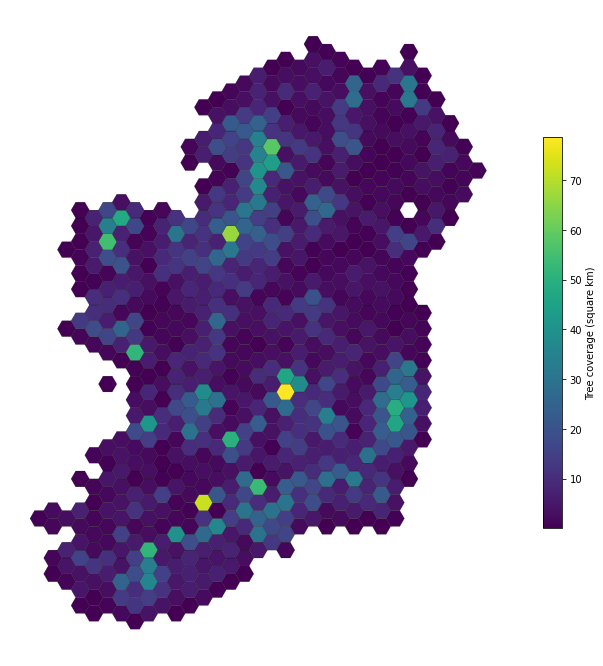

In [297]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
gdf.plot(column='value',ec='black',lw=0.2,legend=True,
          legend_kwds={'label': "Tree coverage (square km)", "shrink": .6},
          ax=ax)
ax.axis('off')